
Veri Boyutu: (100000, 9)

İlk 5 Kayıt:
                                               customer_id  article_id  price  \
3897372  541cc987748427de74176de90683c2a6091dcfe5071e4e...   659132022   0.02   
651720   eff7d128a2fb85600a187b894a780742c2d02bc04e8614...   658329018   0.02   
2757009  debf03f157fb6b56c590d0f94f7c1ec90a54100f1be62a...   876127002   0.01   
294076   4dd9fefdcd85736f8564ca7498269e402f890a8feca509...   688558022   0.02   
257075   82c1c4f0f092ecff14a455747086d328d855b62ffbe023...   448509029   0.04   

        is_campaign  customer_age index_group_name department_name  \
3897372           f          52.0       Ladieswear          Jersey   
651720            f          55.0         Menswear    Jersey Fancy   
2757009           t          42.0          Divided         Dresses   
294076            f          30.0          Divided         Basic 1   
257075            f          35.0          Divided        Trousers   

        perceived_colour_value_name       t_dat  
38

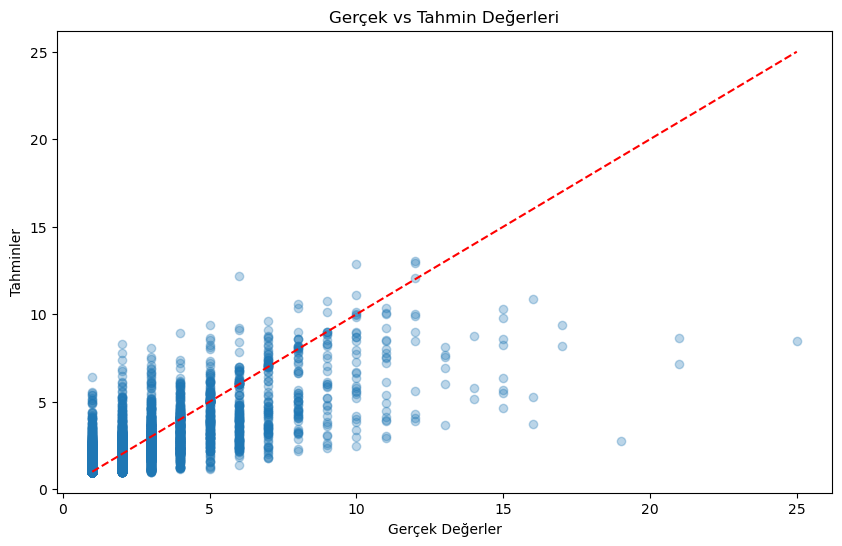


Örnek Stok Önerileri:
   article_id  predicted_demand  safety_stock  reorder_point  current_stock  \
0       38334          1.157778      0.231556       1.389334              0   
1        5222          2.579511      0.515902       3.095413              7   
2       27505          3.521486      0.704297       4.225783              2   
3       11671          1.790486      0.358097       2.148583              3   
4        6545          2.206052      0.441210       2.647263              9   
5       22718          1.004198      0.200840       1.205037              6   
6       45963          4.323982      0.864796       5.188778              6   
7       10406          1.556732      0.311346       1.868078              4   
8       52559          2.160908      0.432182       2.593090              0   
9       52014          2.037527      0.407505       2.445032              1   

   recommended_order  
0           1.389334  
1           0.000000  
2           2.225783  
3           0.0

In [40]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_inspect_data(filepath):
    try:
        df = pd.read_csv(filepath)
        df = df.sample(n=100000, random_state=42)
        
        print("\nVeri Boyutu:", df.shape)
        print("\nİlk 5 Kayıt:")
        print(df.head())
        print("\nEksik Değerler:")
        print(df.isnull().sum())
        print("\nTemel İstatistikler:")
        print(df.describe())
        
        return df
    except Exception as e:
        print(f"Veri yükleme hatası: {e}")
        return None

def clean_and_preprocess(df):
    try:
        df['t_dat'] = pd.to_datetime(df['t_dat'], errors='coerce')
        
        if 'is_campaign' in df.columns:
            df['is_campaign'] = df['is_campaign'].replace({'f': 0, 't': 1})
        
        if 'customer_age' in df.columns:
            df['customer_age'] = df['customer_age'].fillna(df['customer_age'].median())
        
        if 'price' in df.columns:
            df = df[(df['price'] > 0) & (df['price'] < df['price'].quantile(0.99))]
        if 'customer_age' in df.columns:
            df = df[(df['customer_age'] >= 18) & (df['customer_age'] <= 100)]
        
        print("\nTemizlendi", df.shape)
        return df
    except Exception as e:
        print(f"Veri temizleme hatası: {e}")
        return None

def create_features(df):
    try:
        if 't_dat' in df.columns:
            df['year'] = df['t_dat'].dt.year
            df['week'] = df['t_dat'].dt.isocalendar().week
            df['month'] = df['t_dat'].dt.month
            df['day_of_week'] = df['t_dat'].dt.dayofweek
            df['season'] = (df['month'] % 12 // 3) + 1
        
        if 'customer_age' in df.columns:
            df['age_group'] = pd.cut(df['customer_age'],
                                   bins=[0, 18, 25, 35, 45, 55, 65, 100],
                                   labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])
        
        if 'article_id' in df.columns and 'price' in df.columns:
            df['product_popularity'] = df.groupby('article_id')['price'].transform('count')
        
        if 'article_id' in df.columns and 'is_campaign' in df.columns:
            df['campaign_ratio'] = df.groupby('article_id')['is_campaign'].transform('mean')
        
        return df
    except Exception as e:
        print(f"Özellik mühendisliği hatası: {e}")
        return None

def prepare_model_data(df):
    try:
        if 'year' not in df.columns and 't_dat' in df.columns:
            df['year'] = df['t_dat'].dt.year
            df['week'] = df['t_dat'].dt.isocalendar().week
        
        required_for_sales = ['article_id', 'year', 'week'] if 'year' in df.columns else ['article_id', 'week']
        weekly_sales = df.groupby(required_for_sales).size().reset_index(name='sales_quantity')
        
        feature_cols = ['price', 'is_campaign', 'customer_age']
        if 'product_popularity' in df.columns:
            feature_cols.append('product_popularity')
        if 'campaign_ratio' in df.columns:
            feature_cols.append('campaign_ratio')
        if 'season' in df.columns:
            feature_cols.append('season')
        
        agg_dict = {
            'price': 'mean',
            'is_campaign': 'mean',
            'customer_age': 'mean'
        }
        
        if 'product_popularity' in df.columns:
            agg_dict['product_popularity'] = 'first'
        if 'campaign_ratio' in df.columns:
            agg_dict['campaign_ratio'] = 'first'
        if 'season' in df.columns:
            agg_dict['season'] = 'first'
        
        features = df.groupby(required_for_sales).agg(agg_dict).reset_index()
        
        model_data = pd.merge(weekly_sales, features, on=required_for_sales, how='outer')
        
        if len(model_data) > 0:
            try:
                model_data['prev_week_sales'] = model_data.groupby('article_id')['sales_quantity'].shift(1)
                model_data['prev_year_same_week_sales'] = model_data.groupby('article_id')['sales_quantity'].shift(52)
            except:
                model_data['prev_week_sales'] = np.nan
                model_data['prev_year_same_week_sales'] = np.nan
        
        numeric_cols = model_data.select_dtypes(include=['int64', 'float64']).columns
        model_data[numeric_cols] = model_data[numeric_cols].fillna(model_data[numeric_cols].median())
        
        categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            model_data[col] = model_data[col].fillna(model_data[col].mode()[0] if len(model_data[col].mode()) > 0 else 'missing')
        
        model_data = model_data.dropna(axis=1, how='all')
        
        if len(model_data) == 0:
            raise ValueError("Temizleme sonrası veri kalmadı")
            
        print(f"\nModel için hazır veri boyutu: {model_data.shape}")
        print("Eksik değer sayısı:\n", model_data.isnull().sum())
        
        return model_data
        
    except Exception as e:
        print(f"Veri hazırlama hatası: {str(e)}")
        
        emergency_data = df[['article_id', 'price', 'is_campaign', 'customer_age']].copy()
        emergency_data['sales_quantity'] = 1  
        emergency_data = emergency_data.dropna()
        
        if len(emergency_data) > 0:
            print(f"Acil durum veri seti oluşturuldu: {emergency_data.shape}")
            return emergency_data
        else:
            raise ValueError("Acil durum veri seti de oluşturulamadı")

def train_and_optimize_model(X_train, y_train):
    try:
        numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])
        
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))])
        
        param_grid = {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [None, 10, 20],
            'regressor__min_samples_split': [2, 5]
        }
        
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
        grid_search.fit(X_train, y_train)
        
        print(f"\nEn iyi parametreler: {grid_search.best_params_}")
        return grid_search.best_estimator_
    except Exception as e:
        print(f"Model eğitimi hatası: {e}")
        return None

def evaluate_and_report(model, X_test, y_test):
    try:
        y_pred = model.predict(X_test)
        
        metrics = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }
        
        print("\nModel Performans Metrikleri:")
        for name, value in metrics.items():
            print(f"{name}: {value:.4f}")
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Gerçek Değerler')
        plt.ylabel('Tahminler')
        plt.title('Gerçek vs Tahmin Değerleri')
        plt.savefig('actual_vs_predicted.png')
        plt.show()
        
        return metrics
    except Exception as e:
        print(f"Değerlendirme hatası: {e}")
        return None

def generate_stock_recommendations(model, X_data, current_stock=None):
    try:
        predictions = model.predict(X_data)
        
        recommendations = pd.DataFrame({
            'article_id': X_data.index,
            'predicted_demand': predictions,
            'safety_stock': predictions * 0.2,
            'reorder_point': predictions * 1.2
        })
        
        if current_stock is not None:
            recommendations = recommendations.merge(current_stock, on='article_id', how='left')
            recommendations['recommended_order'] = np.maximum(
                recommendations['reorder_point'] - recommendations['current_stock'],
                0
            )
        
        recommendations.to_csv('stock_recommendations.csv', index=False)
        print("\nÖrnek Stok Önerileri:")
        print(recommendations.head(10))
        
        return recommendations
    except Exception as e:
        print(f"Stok önerisi oluşturma hatası: {e}")
        return None

def main():
    df = load_and_inspect_data('campaign_data.csv')
    if df is None:
        print("Veri yükleme başarısız. Program sonlandırılıyor.")
        return
    
    df = clean_and_preprocess(df)
    if df is None:
        print("Veri temizleme başarısız. Program sonlandırılıyor.")
        return
    
    df = create_features(df)
    if df is None:
        print("Özellik mühendisliği başarısız. Program sonlandırılıyor.")
        return
    
    model_data = prepare_model_data(df)
    if model_data is None:
        print("Model verisi hazırlama başarısız. Program sonlandırılıyor.")
        return
    
    try:
        if 'sales_quantity' not in model_data.columns:
            model_data['sales_quantity'] = 1
            
        X = model_data.drop(['sales_quantity', 'article_id'], axis=1, errors='ignore')
        y = model_data['sales_quantity']
        
        if len(model_data) < 100:
            print("Uyarı: Veri çok az, tüm veri eğitim için kullanılacak")
            X_train, X_test, y_train, y_test = X, X, y, y
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    except Exception as e:
        print(f"Veri bölme hatası: {e}")
        return
    
    model = train_and_optimize_model(X_train, y_train)
    if model is None:
        print("Model eğitimi başarısız. Program sonlandırılıyor.")
        return
    
    metrics = evaluate_and_report(model, X_test, y_test)
    if metrics is None:
        print("Değerlendirme başarısız. Program sonlandırılıyor.")
        return
    
    current_stock = pd.DataFrame({
        'article_id': X_test.index,
        'current_stock': np.random.randint(0, 10, size=len(X_test))
    })
    recommendations = generate_stock_recommendations(model, X_test, current_stock)
    
    try:
        joblib.dump(model, 'stock_optimization_model.pkl')
        print("\nModel başarıyla kaydedildi: stock_optimization_model.pkl")
    except Exception as e:
        print(f"Model kaydetme hatası: {e}")

if __name__ == "__main__":
    main()